# Supp. figure 2 and 3: prior and posterior predictives, conditional posteriors

The training data and inference objects are pre computed and only loaded for visualization in this notebook.

For details on how to perform inference, see `/tutorials` or `/scripts`


In [1]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib import rcParams
import numpy as np
import pickle
import sys
import torch

sys.path.append("../")
from plotting_utils import custom_marginal_plot

from sbi.simulators import simulate_in_batches
from sbi.inference import prepare_for_sbi
from sbi.analysis import pairplot, conditional_pairplot
from sbi.inference import SNPE

from consbi import DATA_PATH, RESULTS_PATH

plt.style.use('../plotting_settings.mplstyle')
%matplotlib inline

# Colorblind color palette
colors = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load literature inference results
with open(RESULTS_PATH.joinpath("npe_measured_data_ss50_ep1295.p"), "rb") as fh:
    prior, posterior, seed, simulator, density_estimator = pickle.load(fh).values()
    
# create new posterior object to bridge from sbi 0.14.2 to 0.19.2
posterior = SNPE(prior).build_posterior(density_estimator=posterior.net, prior=prior)


## Load predictive samples and data

In [3]:
xo = torch.tensor(simulator.constraints["observables"]).reshape(1, -1)
posterior.set_default_x(xo)
obs_labels = [r"L4", r"L4SEP", r"L4SP", r"L4SS", r"L5IT", r"L5PT", r"L6"]
param_labels = [r"$\theta_{pre}$", r"$\theta_{post}$", r"$\theta_{postAll}$"]

In [4]:
# load samples
with open("posterior_predictive_samples.p", "rb") as fh: 
    thos_dso, xos_dso = pickle.load(fh).values()
    
with open(RESULTS_PATH.joinpath("prior_predictive_samples_dso.p"), "rb") as fh: 
    ths_dso, xs_dso = pickle.load(fh).values()
    
with open(RESULTS_PATH.joinpath("distance-based-rules-comparison.p"), "rb") as fh:
    xs_dis, xos_dis, xos_fixed, maps, features, ths_dis, thos_dis = pickle.load(fh).values()

ndims = ths_dso.shape[1]
xs_dis = torch.cat(xs_dis, dim=0)

## Marginal plots for predictive posteriors

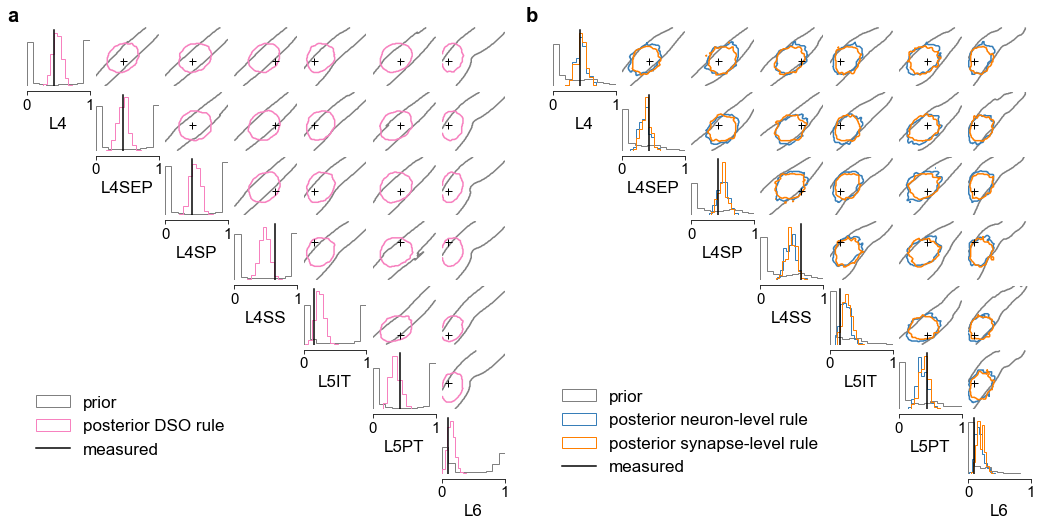

In [13]:
fig = plt.figure(figsize=(18, 8))
outer_grid = fig.add_gridspec(1, 2, wspace=.1, hspace=0, width_ratios=[.5, .5])
num_samples = 10000
# set KDE values
kde_bins = 100
hist_bins = 10
bw_method = 0.3
dim_data = 7
dim_params = 3

# left column
left_grid = outer_grid[0, 0].subgridspec(dim_data, dim_data, wspace=0.1, hspace=0.1)
ax1 = left_grid.subplots()  # Create all subplots for the inner

# right column
right_grid = outer_grid[0, 1].subgridspec(dim_data, dim_data, wspace=0.1, hspace=0.1)
ax3 = right_grid.subplots()


pairplot_opts = dict(upper="kde", 
                      diag="kde",
                      contour_offdiag=dict(levels=[0.99]), 
                      points_colors=["k"],
                      points_offdiag=dict(marker="+", markersize=7), 
                      kde_offdiag=dict(bins=kde_bins, bw_method=bw_method),
                      kde_diag=dict(bins=kde_bins, bw_method=bw_method),
                      labels = param_labels,
           )


## posterior predictives DSO
fig, ax1 = pairplot([xs_dso[:num_samples], xos_dso[:num_samples]], 
                    points=xo.squeeze(), limits=[[0, 1]]*7, 
                    labels=obs_labels, 
                    points_offdiag=pairplot_opts["points_offdiag"],
                    points_colors=["k"],
                    upper="contour", 
                    kde_offdiag=dict(bins=kde_bins, bw_method=bw_method),
                    contour_offdiag=dict(levels=[0.99]),
                    diag="hist",
                    hist_diag=dict(bins=hist_bins, histtype="step", density=True),
                    samples_colors=["gray", colors[3]],
                    axes=ax1, 
                    fig=fig,
                   )

plt.sca(ax1[0, 0])
plt.legend(["prior", "posterior DSO rule", "measured"], 
           bbox_to_anchor=(-.1, -5), 
           loc=2)

## Posterior predictive distance-rules
fig, ax3 = pairplot([xs_dis, xos_dis[-1], xos_dis[0]], 
                    points=xo.squeeze(), limits=[[0, 1]]*7, 
                    labels=obs_labels, 
                    points_offdiag=pairplot_opts["points_offdiag"],
                    points_colors=["k"],
                    upper="contour", 
                    kde_offdiag=dict(bins=kde_bins, bw_method=bw_method),
                    contour_offdiag=dict(levels=[0.99]),
                    diag="hist",
                    hist_diag=dict(bins=hist_bins, histtype="step", density=True),
                    samples_colors=["gray", colors[0], colors[1]],
                    axes=ax3, 
                    fig=fig,
                   )

plt.sca(ax3[0, 0])
plt.legend(["prior", "posterior neuron-level rule", "posterior synapse-level rule", "measured"], 
           bbox_to_anchor=(-.1, -4.9), 
           loc=2)

# Add Letters.
weight = "bold"
fontsize = 20
y = 0.91
x = 0.11
dx = .4
dx2 = 0.55
fig.text(x, y, "a", fontsize=fontsize, fontweight=weight)
fig.text(x + dx, y, "b", fontsize=fontsize, fontweight=weight);

In [14]:
for ftype in ["png", "pdf",]:
    fig.savefig(f"supp_fig2_posterior_predictives.{ftype}", dpi=300, bbox_inches='tight')

## Conditional posterior marginal plots

We visualize the posteriors obtained from conditioning not only on `x_o` but also on subsets of the parameter vector, e.g., conditioning on `theta_1` and sampling only `theta_2` and `theta_3`. 

In [15]:
from sbi.inference.potentials import posterior_estimator_based_potential
from sbi.analysis import conditional_potential
from sbi.inference import MCMCPosterior
# to speed up sampling
from joblib import Parallel, delayed

In [22]:
# get posterior potential function.
potential_fn, theta_transform = posterior_estimator_based_potential(
    posterior.posterior_estimator, prior=prior, x_o=xo
)

In [18]:
# define sample fun for joblib
def sample_fun(condition):
    conditioned_potential_fn, restricted_tf, restricted_prior = conditional_potential(
        potential_fn=potential_fn,
        theta_transform=theta_transform,
        prior=prior,
        condition=condition,
        dims_to_sample=dims,
    )

    mcmc_posterior = MCMCPosterior(
        potential_fn=conditioned_potential_fn,
        theta_transform=restricted_tf,
        proposal=restricted_prior,
        num_chains=20,
        method="slice_np_vectorized",
    )
    return mcmc_posterior.sample((num_samples,), show_progress_bars=False)

In [19]:
num_conditions = 1
num_samples = 1000
num_workers = 1
cond_samples = []
seed = 42  # seed for condition
conditions = posterior.sample((num_conditions,), x=xo)

for dims in [[0, 1], [0, 2], [1, 2]]:
    
    ss = Parallel(n_jobs=num_workers, prefer="threads")(
        delayed(sample_fun)(condition) for condition in conditions
    )
    cond_samples.append(torch.stack(ss))

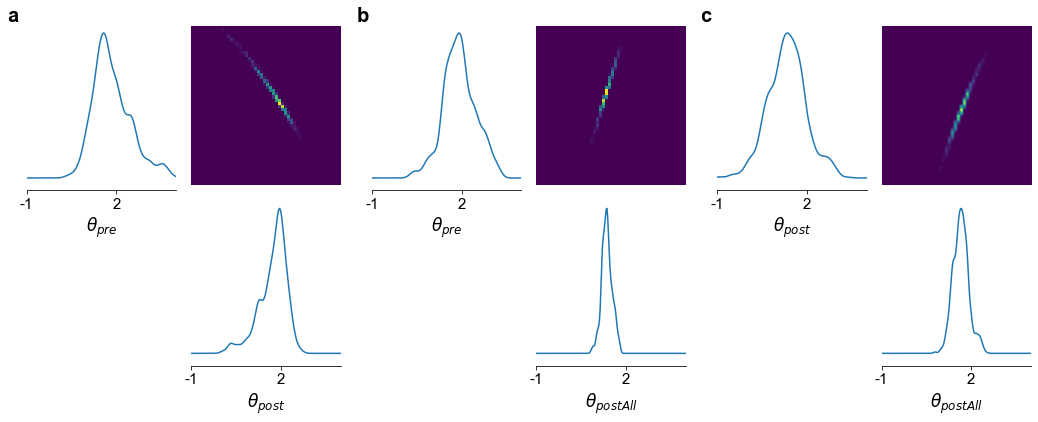

In [20]:
fig = plt.figure(figsize=(18, 6))
outer_grid = fig.add_gridspec(1, 3, wspace=0.1, hspace=0, width_ratios=[.33, .33, .33])

# left column
ax1 = outer_grid[0, 0].subgridspec(2, 2, wspace=0.1, hspace=0.1).subplots(subplot_kw=dict(sharex=True))
ax2 = outer_grid[0, 1].subgridspec(2, 2, wspace=0.1, hspace=0.1).subplots(subplot_kw=dict(sharex=True))
ax3 = outer_grid[0, 2].subgridspec(2, 2, wspace=0.1, hspace=0.1).subplots(subplot_kw=dict(sharex=True))

kwargs = dict(diag="kde", kde_diag=dict(bw_method=0.2, bins=200),
              hist_diag=dict(bins=15, density=True), 
              limits=[[-1, 4]] * 3, 
              ticks =[[-1, 2]] * 3,
             )

fig, ax1 = pairplot(cond_samples[0].squeeze(), fig=fig, axes=ax1, 
                    labels=[param_labels[0], param_labels[1]],
                    **kwargs)
fig, ax2 = pairplot(cond_samples[1].squeeze(), fig=fig, axes=ax2, 
                    labels=[param_labels[0], param_labels[2]],
                    **kwargs)
fig, ax3 = pairplot(cond_samples[2].squeeze(), fig=fig, axes=ax3, 
                    labels=[param_labels[1], param_labels[2]],
                    **kwargs)

# Add Letters.
weight = "bold"
fontsize = 20
y = 0.91
x = 0.11
dx = .27
dx2 = 0.535
fig.text(x, y, "a", fontsize=fontsize, fontweight=weight)
fig.text(x + dx, y, "b", fontsize=fontsize, fontweight=weight)
fig.text(x + dx2, y, "c", fontsize=fontsize, fontweight=weight);

In [21]:
for ftype in ["png", "pdf",]:
    fig.savefig(f"supp_fig3_conditional_posteriors.{ftype}", dpi=300, bbox_inches='tight')